**References:** Chapter 17 of Geron's book. For 1-Dim plots, Keras tutorial : https://www.tensorflow.org/tutorials/generative/autoencoder

This file trains a modified VAE (with a different sampling layer and a different loss function) with the instances of the normal digits in the training data. 

Then, it measures the reconstruction loss for the digits in the test data.

The reconstruction loss for the instances of the abnormal digits in the test data is higher.

A threshold is determined based on the distribution of the reconstruction losses of the normal training data (threshold = mean + 2.5*std of this distribution).  

Then, if the reconstruction loss of a digit in the test data is higher than this threshold, it is classified as abnormal.

By comparing with the known labels of test data (with T for normal digit(s) and F for abnormal digit(s)), the confusion matrix and the accuracy is calculated. 

In [1]:
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split

### **Loading the MNIST data and forming arrays of the normal training data, the validation data (normal and abnormal) and the test data (normal and abnormal)**

In [3]:
abn = 8  # Abnormal digit(s)

(x_train_0, y_train_0), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train_0 = x_train_0.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255

train_size = x_train_0.shape[0] * 9 // 10

x_train, x_valid, y_train, y_valid = train_test_split(x_train_0, y_train_0, train_size = train_size)

normal_data = x_train[y_train != abn]        # Normal training data (Normal digitss)
normal_labels = y_train[y_train != abn]

valid_data = x_valid                         # Test data (both normal digits and the abnormal digit)
valid_labels = y_valid

test_data = x_test                           # Test data (both normal digits and the abnormal digit)
test_labels = y_test

test_labels_T_F = np.where(test_labels != abn, True, False)
# Array of T and F, T where test digits are normal and F where test digits are abnormal

valid_labels_T_F = np.where(valid_labels != abn, True, False) 
# Array of T and F, T where test digits are normal and F where test digits are abnormal

11501568/11490434 [==============================] - 0s 0us/step


In [4]:
normal_data.shape, normal_labels.shape, valid_data.shape, valid_labels.shape, test_data.shape, test_labels.shape

((48752, 28, 28), (48752,), (6000, 28, 28), (6000,), (10000, 28, 28), (10000,))

In [5]:
normal_test_data = test_data[test_labels != abn]                   # The normal digits in the test data
abnormal_test_data = test_data[test_labels == abn]                 # The abnormal digits in the test data
normal_test_labels = test_labels[test_labels != abn]               # Their labels
abnormal_test_labels = test_labels[test_labels == abn]             # Their labels

In [6]:
normal_test_data.shape, abnormal_test_data.shape 

((9026, 28, 28), (974, 28, 28))

In [7]:
normal_valid_data = valid_data[valid_labels != abn]                  # The normal digits in the valid data
abnormal_valid_data = valid_data[valid_labels == abn]                 # The abnormal digits in the valid data
normal_valid_labels = valid_labels[valid_labels != abn]               # Their labels
abnormal_valid_labels = valid_labels[valid_labels == abn]             # Their labels

In [8]:
normal_valid_data.shape, abnormal_valid_data.shape

((5397, 28, 28), (603, 28, 28))

### **Building and training the network** 

In [9]:
K = keras.backend
# def rounded_accuracy(y_true, y_pred):
  #  return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [10]:
# Modified sampling layer with the addition of mean_2, log_var_2, and fraction p, with
# the appropriate change in the reparametrization trick to do stochastic 
# sampling from the superposition of the two MVN distributions, while allowing
# the 5 parallel layers containing the means and stds of the two MVNs and the fractions p's
# for each dimension to be trained via backpropogation of the error signal.
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean_1, log_var_1, mean_2, log_var_2, p = inputs
        return (K.random_normal(tf.shape(log_var_1)) * K.exp(log_var_1 / 2) + mean_1)*p + (K.random_normal(tf.shape(log_var_2)) * K.exp(log_var_2 / 2) + mean_2)*(1 - p)

In [11]:
# For details please see Geron's book. 
codings_size = 16  # The number of dimensions of the two MVN distributions in the sampling layer

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(256, activation="selu")(z)
z = keras.layers.Dense(128, activation="selu")(z)
z = keras.layers.Dense(64, activation="selu")(z)

# Adding output nodes (parallel layers) at the end of the encoder for means 
# and standard deviations of a second Multivariate Normal (MVN) distribution 
# in the dimensions of the coding size (here 32). In each of the dimensions,
# this first MVN is multiplied by a fraction p and added to the second MVN
# multiplied by 1 - p in each dimension.
# final distribution = p * first MVN + (1 - p) * second MVN
# Another parallel layer (set of nodes) is added to keep and train the fractions p's
# in each dimension 
codings_mean_1 = keras.layers.Dense(codings_size)(z)
codings_log_var_1 = keras.layers.Dense(codings_size)(z)
codings_mean_2 = keras.layers.Dense(codings_size)(z)
codings_log_var_2 = keras.layers.Dense(codings_size)(z)
codings_p = keras.layers.Dense(1, activation='sigmoid')(z)

# Modified sampling layer at the end of the encoder
codings = Sampling()([codings_mean_1, codings_log_var_1, codings_mean_2, codings_log_var_2, codings_p])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean_1, codings_log_var_1, codings_mean_2, codings_log_var_2, codings_p, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(64, activation="selu")(decoder_inputs)
x = keras.layers.Dense(128, activation="selu")(x)
x = keras.layers.Dense(256, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, _, _, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

# New latent loss function that will be added to the reconstruction binary cross-entropy loss
# The whole network (Encoder, sampling layer, and decoder) will train to minimize this loss
p_mean = K.mean(codings_p)
array1 = p_mean*(codings_log_var_1 - K.exp(codings_log_var_1) - K.square(codings_mean_1))
array2 = (1-p_mean)*(codings_log_var_2 - K.exp(codings_log_var_2) - K.square(codings_mean_2)) # *  codings_ratio
sum1 = K.sum(1 + array1, axis=-1)
sum2 = K.sum(1 + array2, axis=-1)

latent_loss = -0.5 * (sum1 + sum2) 

latent_loss = latent_loss * 16

# Add the latent loss to the reconstruction loss
variational_ae.add_loss(K.mean(latent_loss) / 784.)

# For the reconstruction loss binary cross-entropy loss is used (same as regular VAE). 
# For details please see Chapter 17 of Geron's book (Stacked AE and VAE sections) 
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop")
history = variational_ae.fit(normal_data, normal_data, epochs=100, batch_size=16,
                             validation_data=(normal_valid_data, normal_valid_data), shuffle=True)

Epoch 1/100
3047/3047 [==============================] - 26s 6ms/step - loss: 0.0982 - val_loss: 0.0857
Epoch 2/100
3047/3047 [==============================] - 16s 5ms/step - loss: 0.0791 - val_loss: 0.0758
Epoch 3/100
3047/3047 [==============================] - 16s 5ms/step - loss: 0.0745 - val_loss: 0.0746
Epoch 4/100
3047/3047 [==============================] - 16s 5ms/step - loss: 0.0726 - val_loss: 0.0711
Epoch 5/100
3047/3047 [==============================] - 16s 5ms/step - loss: 0.0711 - val_loss: 0.0758
Epoch 6/100
3047/3047 [==============================] - 15s 5ms/step - loss: 0.0703 - val_loss: 0.0747
Epoch 7/100
3047/3047 [==============================] - 15s 5ms/step - loss: 0.0698 - val_loss: 0.0692
Epoch 8/100
3047/3047 [==============================] - 15s 5ms/step - loss: 0.0692 - val_loss: 0.0685
Epoch 9/100
3047/3047 [==============================] - 15s 5ms/step - loss: 0.0688 - val_loss: 0.0677
Epoch 10/100
3047/3047 [==============================] - 16s 5m

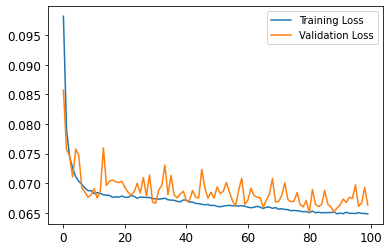

In [12]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [13]:
model = variational_ae
model.summary(expand_nested=True, show_trainable=True)

Model: "model_2"
_____________________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     Trainable  
 input_1 (InputLayer)           [(None, 28, 28)]     0           []                               Y          
                                                                                                             
 model (Functional)             [(None, 16),         246337      ['input_1[0][0]']                Y          
                                 (None, 16),                                                                 
                                 (None, 16),                                                                 
                                 (None, 16),                                                                 
                                 (None, 1),                                                            

In [14]:
model_encoder = variational_encoder
# model_encoder.summary(expand_nested=True, show_trainable=True)

In [15]:
model_decoder = variational_decoder
# model_decoder.summary(expand_nested=True, show_trainable=True)

In [16]:
model_layers = np.array(model.layers)
n_layers = model_layers.shape[0] 
# np.concatenate((np.arange(n_layers).reshape(n_layers,1), model_layers.reshape(n_layers,1)), axis = 1)

### **The original and reconstructed images for the first 30 instances of the normal training data, validation data, normal validation data, abnormal validation data, test data, normal test data, and abnormal test data**

In [17]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [18]:
def show_reconstructions(model, images=test_data, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

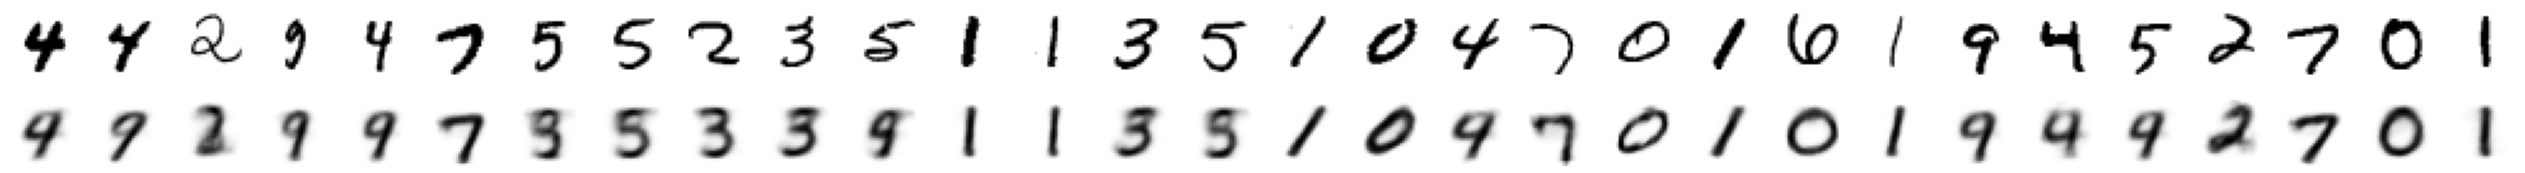

In [19]:
show_reconstructions(variational_ae, normal_data, 30)
plt.show()

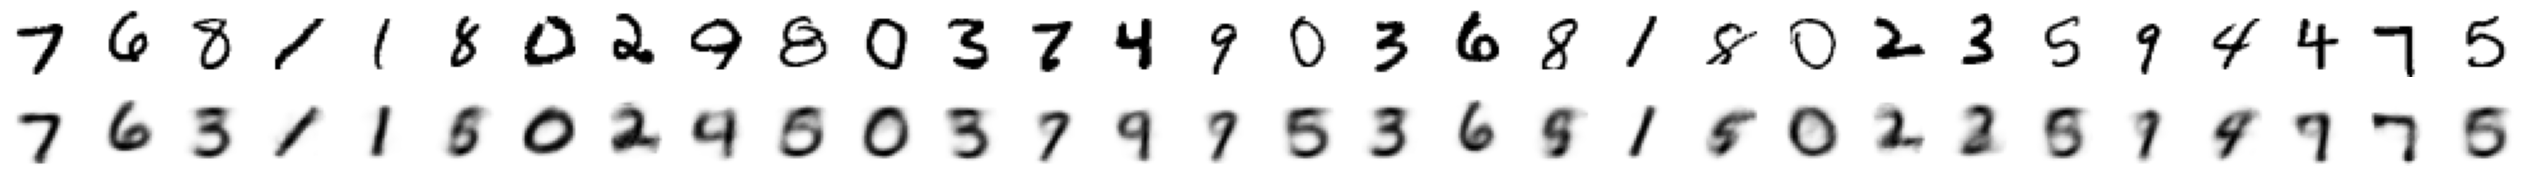

In [20]:
show_reconstructions(variational_ae, valid_data, 30)
plt.show()

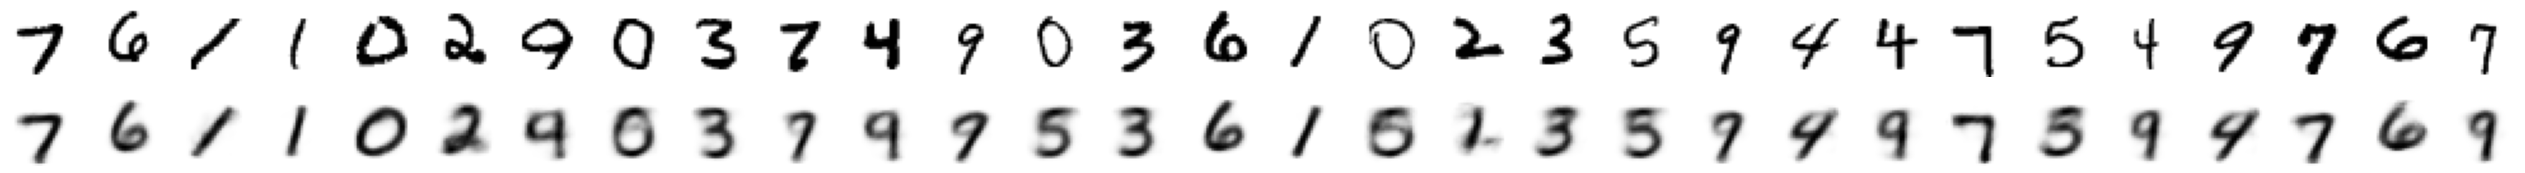

In [21]:
show_reconstructions(variational_ae, normal_valid_data, 30)
plt.show()

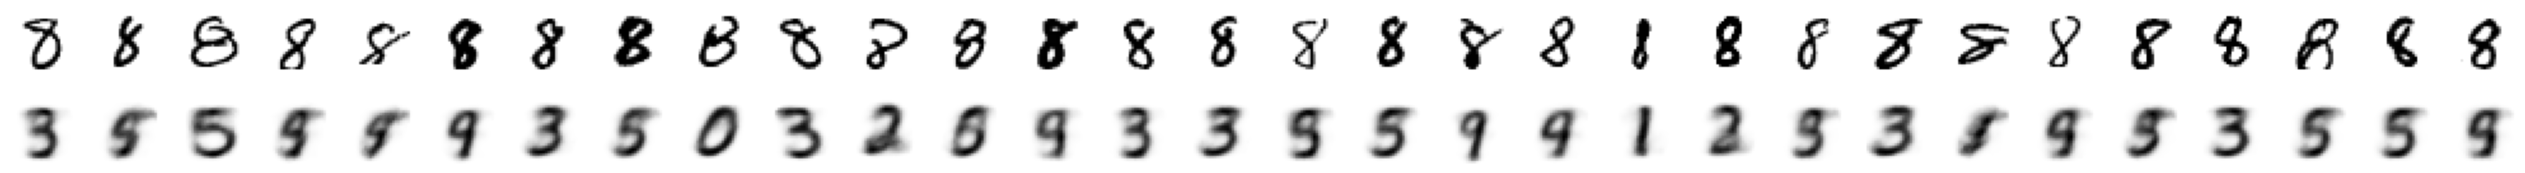

In [22]:
show_reconstructions(variational_ae, abnormal_valid_data, 30)
plt.show()

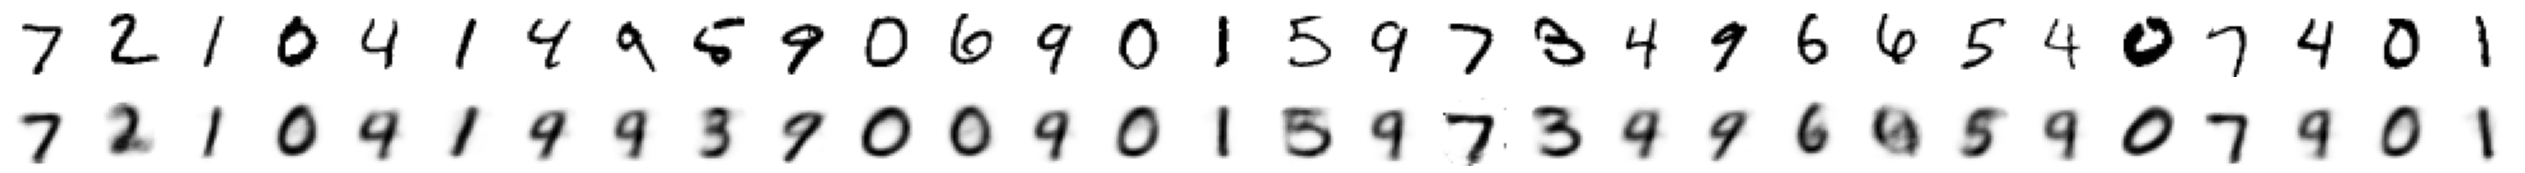

In [23]:
show_reconstructions(variational_ae, test_data, 30)
plt.show()

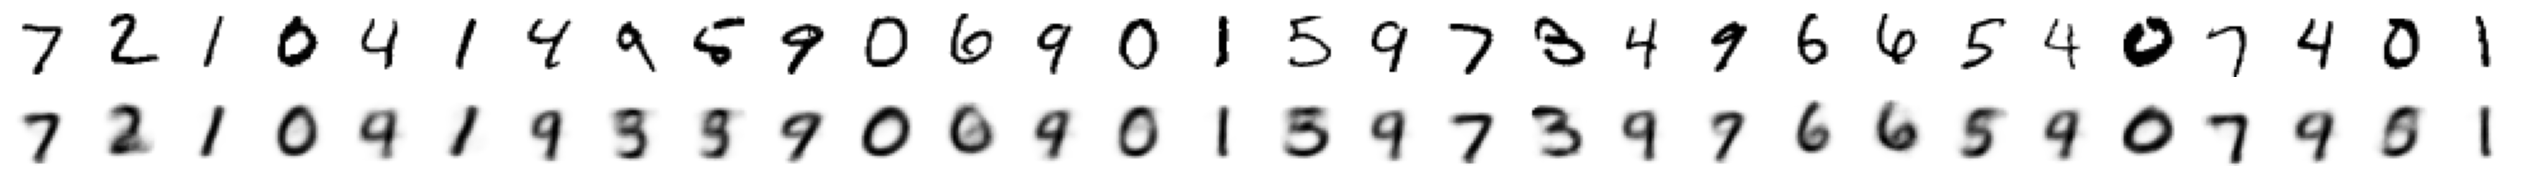

In [24]:
show_reconstructions(variational_ae, normal_test_data, 30)
plt.show()

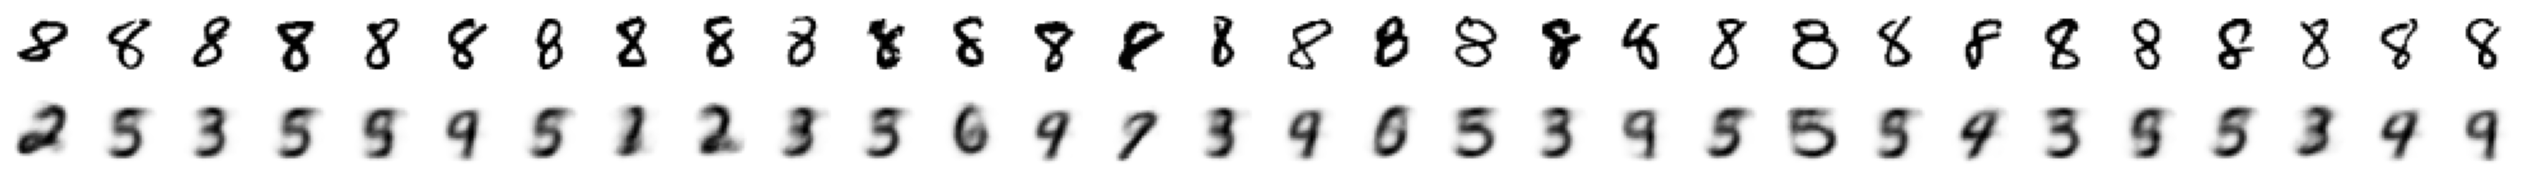

In [25]:
show_reconstructions(variational_ae, abnormal_test_data, 30)
plt.show()

**1-Dim plot of pixels of the first normal test data**

In [26]:
reconstructions_nl_test = variational_ae.predict(normal_test_data)

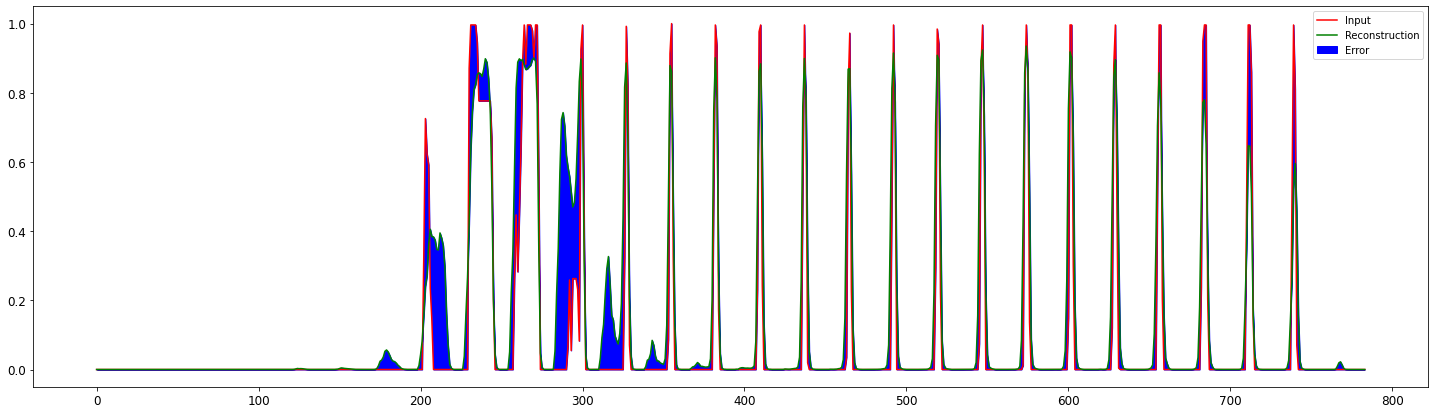

In [27]:
plt.figure(figsize=(25,7))
plt.plot(normal_test_data[0].ravel(), 'r')
plt.plot(reconstructions_nl_test[0].ravel(), 'g')
plt.fill_between(np.arange(28*28), reconstructions_nl_test[0].ravel(), normal_test_data[0].ravel(), color='blue')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

**1-Dim plot of pixels of the first abnormal test data**

In [28]:
reconstructions_abn_test = variational_ae.predict(abnormal_test_data)

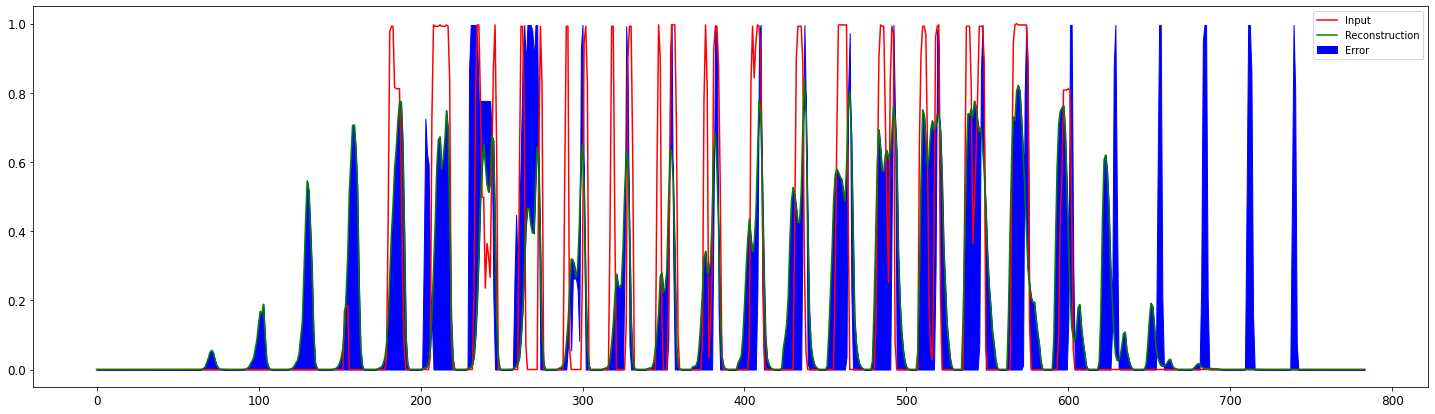

In [29]:
plt.figure(figsize=(25,7))
plt.plot(abnormal_test_data[0].ravel(), 'r')
plt.plot(reconstructions_abn_test[0].ravel(), 'g')
plt.fill_between(np.arange(28*28), reconstructions_abn_test[0].ravel(), normal_test_data[0].ravel(), color='blue')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### **Distributions of the reconstruction losses and the calculation of the threshold.**

**Distribution of the reconstruction losses of the normal training data**

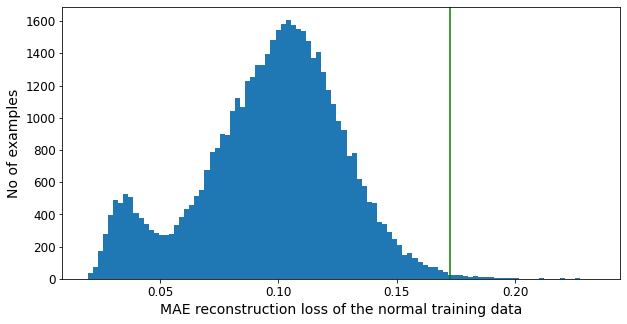

In [30]:
reconstructions = variational_ae.predict(normal_data)
train_loss = tf.keras.losses.mae(reconstructions.reshape(-1, 784), normal_data.reshape(-1, 784))
plt.figure(figsize=(10,5))
plt.hist(train_loss[None,:], bins=100)
threshold1 = np.mean(train_loss) + 2.5*np.std(train_loss)
plt.axvline(threshold1,c='g')
plt.xlabel("MAE reconstruction loss of the normal training data")
plt.ylabel("No of examples")
plt.show()

In [31]:
print("Mean: ", np.mean(train_loss))
print("Std: ", np.std(train_loss))

Mean:  0.09681456
Std:  0.030289158


In [32]:
threshold_train_mean_2_5_std = np.mean(train_loss) + 2.5*np.std(train_loss)
print("Threshold based on the mean of the training data MAE reconstruction losses + 2.5 std: ", threshold_train_mean_2_5_std)

Threshold based on the mean of the training data MAE reconstruction losses + 2.5 std:  0.1725374534726143


In [33]:
threshold1 = threshold_train_mean_2_5_std

**Distribution of the reconstruction losses of the abnormal validation data**

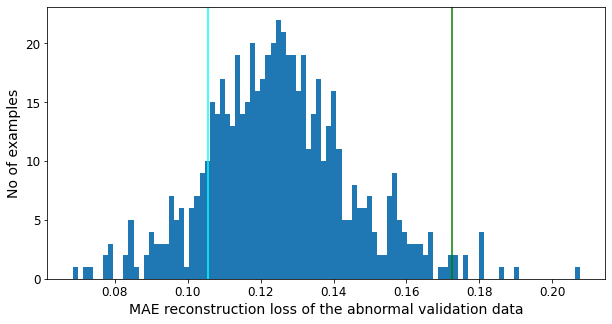

In [34]:
reconstructions = variational_ae.predict(abnormal_valid_data)
abn_valid_loss = tf.keras.losses.mae(reconstructions.reshape(-1,784), abnormal_valid_data.reshape(-1,784))
plt.figure(figsize=(10,5))
plt.hist(abn_valid_loss[None, :], bins=100)
threshold2 = np.mean(abn_valid_loss) - np.std(abn_valid_loss)
plt.axvline(threshold2,c='cyan')
plt.axvline(threshold1,c='g')
plt.xlabel("MAE reconstruction loss of the abnormal validation data")
plt.ylabel("No of examples")
plt.show()

In [35]:
abnormal_valid_mean_loss = np.mean(abn_valid_loss)

In [36]:
abnormal_valid_mean_loss , np.std(abn_valid_loss)

(0.12542142, 0.01985663)

In [37]:
threshold2 = abnormal_valid_mean_loss - np.std(abn_valid_loss)
print("Threshold2: ", threshold2)

Threshold2:  0.10556479


**Distribution of the reconstruction losses of the normal validation data**

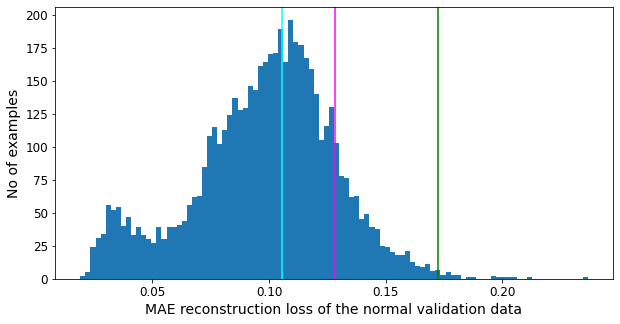

In [38]:
reconstructions = variational_ae.predict(normal_valid_data)
nl_valid_loss = tf.keras.losses.mae(reconstructions.reshape(-1,784), normal_valid_data.reshape(-1,784))
plt.figure(figsize=(10,5))
plt.hist(nl_valid_loss[None, :], bins=100)
threshold3 = np.mean(nl_valid_loss) + np.std(nl_valid_loss)
plt.axvline(threshold3, c='magenta')
plt.axvline(threshold2, c='cyan')
plt.axvline(threshold1, c='g')
plt.xlabel("MAE reconstruction loss of the normal validation data")
plt.ylabel("No of examples")
plt.show()

In [39]:
normal_valid_mean_loss = np.mean(nl_valid_loss)

In [40]:
normal_valid_mean_loss , np.std(nl_valid_loss)

(0.098013066, 0.030395722)

In [41]:
threshold3 = normal_valid_mean_loss + np.std(nl_valid_loss)
print("Threshold3: ", threshold3)

Threshold3:  0.12840879


**Calculation of a preliminary threshold based on (threshold2 + threshold3) / 2 = Average of (mean + std of the distribution of the reconstruction losses of the normal validation data) and (mean - std of the distribution of the reconstruction losses of the abnormal validation data)**

In [42]:
Avg_of_threshold_2_3 = (threshold2 + threshold3)/2
print("Average of threshold 2 and 3: ", Avg_of_threshold_2_3)

Average of threshold 2 and 3:  0.11698678880929947


In [43]:
threshold4 = Avg_of_threshold_2_3

### **Calculation of the threshold that gives the best accuracy on the validation data and set this as the threshold.**

In [44]:
def predict(model, data, threshold):
  reconstructions = model.predict(data)
  loss = tf.keras.losses.mae(reconstructions.reshape(-1, 784), data.reshape(-1, 784))
  return tf.math.less(loss, threshold)

In [45]:
increment = (abnormal_valid_mean_loss- normal_valid_mean_loss)/100
thresholds = np.arange(normal_valid_mean_loss, abnormal_valid_mean_loss, increment)
thrs_size = thresholds.shape[0]
accuracies = np.zeros(thrs_size)
for i in range(thrs_size):
  preds = predict(variational_ae, valid_data, thresholds[i])
  accuracies[i] = accuracy_score(preds, valid_labels_T_F)
argmax = np.argmax(accuracies)
valid_data_best_threshold = thresholds[argmax]
print("The best threshold based on validation data: ", valid_data_best_threshold)

The best threshold based on validation data:  0.12514733619987906


In [46]:
thr_acc = np.zeros((thrs_size, 2))
thr_acc[:, 0] = thresholds
thr_acc[:, 1] = accuracies
thr_acc[argmax-2:argmax+3]

array([[0.12459917, 0.7875    ],
       [0.12487325, 0.78933333],
       [0.12514734, 0.79533333]])

In [47]:
threshold5 = valid_data_best_threshold

In [48]:
threshold = threshold5

#### **Distribution of the reconstruction losses of all the validation data (normal and abnormal)**

The blue line is threshold4 (= the average of threshold3 [magenta] and threshold2 [cyan]). 

The red line is the threshold that gives the best accuracy for the validation data.

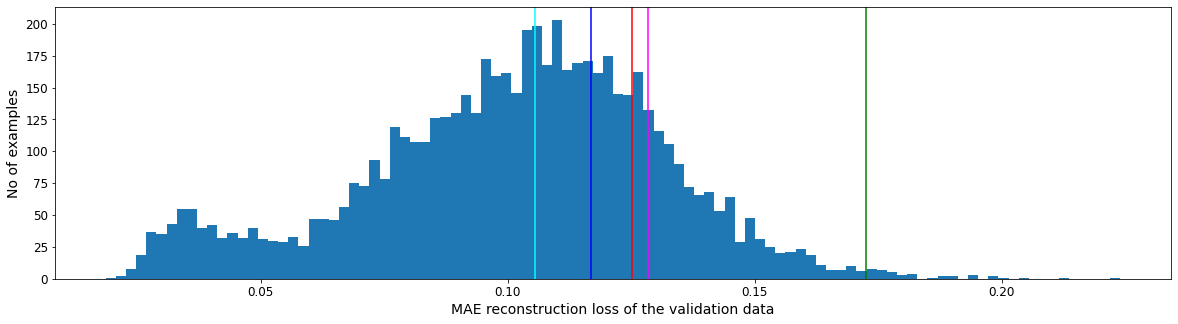

In [49]:
reconstructions = variational_ae.predict(valid_data)
valid_loss = tf.keras.losses.mae(reconstructions.reshape(-1,784), valid_data.reshape(-1,784))
plt.figure(figsize=(20,5))
plt.hist(valid_loss[None, :], bins=100)
plt.axvline(threshold, c='r')
plt.axvline(threshold4, c='b')
plt.axvline(threshold2, c='cyan')
plt.axvline(threshold3, c='magenta')
plt.axvline(threshold1, c='green')
plt.xlabel("MAE reconstruction loss of the validation data")
plt.ylabel("No of examples")
plt.show()

#### **Distribution of the reconstruction losses of the test data (normal and abnormal)**

The blue line is threshold4 (= the average of threshold3 [magenta] and threshold2 [cyan]). 

The red line is the threshold that gives the best accuracy for the validation data.

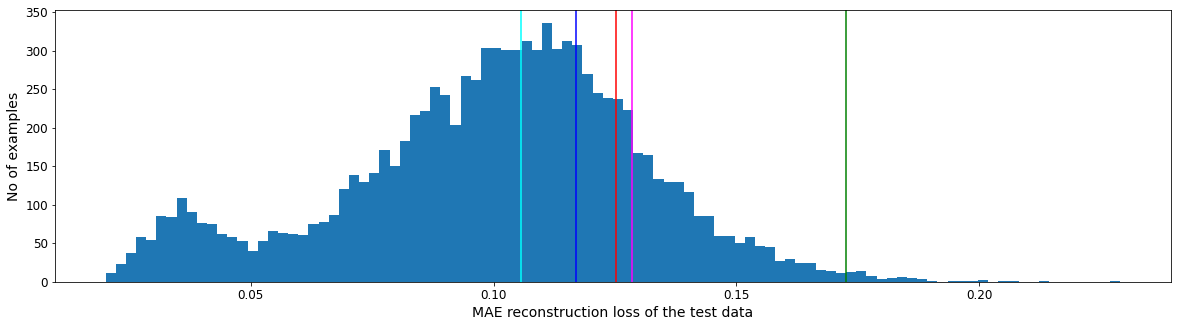

In [50]:
reconstructions = variational_ae.predict(test_data)
test_loss = tf.keras.losses.mae(reconstructions.reshape(-1,784), test_data.reshape(-1,784))
plt.figure(figsize=(20,5))
plt.hist(test_loss[None, :], bins=100)
plt.axvline(threshold, c='r')
plt.axvline(threshold4, c='b')
plt.axvline(threshold2, c='cyan')
plt.axvline(threshold3, c='magenta')
plt.axvline(threshold1, c='green')
plt.xlabel("MAE reconstruction loss of the test data")
plt.ylabel("No of examples")
plt.show()

#### **Mean and standard deviation of reconstruction losses for normal and abnormal test data**

In [51]:
reconstructions = variational_ae.predict(normal_test_data)
nl_test_loss = tf.keras.losses.mae(reconstructions.reshape(-1,784), normal_test_data.reshape(-1,784))
np.mean(nl_test_loss) , np.std(nl_test_loss)

(0.097193986, 0.030281436)

In [52]:
reconstructions = variational_ae.predict(abnormal_test_data)
abn_test_loss = tf.keras.losses.mae(reconstructions.reshape(-1,784), abnormal_test_data.reshape(-1,784))
np.mean(abn_test_loss) , np.std(abn_test_loss)

(0.1265206, 0.019742802)

### **Calculation of the accuracy and the confusion matrix on the test data with threshold set based on the best threshold from the validation data**

In [53]:
# def predict(model, data, threshold):
#  reconstructions = model.predict(data)
#  loss = tf.keras.losses.mae(reconstructions.reshape(-1, 784), data.reshape(-1, 784))
#  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  cf = confusion_matrix(labels, predictions)
  print("Confusion Matrix: \n prediction: F      T ")
  print("             {}   {}".format(preds[preds == False].shape[0], preds[preds == True].shape[0]))
  print(" label: F   [[{}   {}]    {}".format(cf[0,0], cf[0,1], test_labels_T_F[test_labels_T_F == False].shape[0]))
  print("        T    [{}   {}]]   {}".format(cf[1,0], cf[1,1], test_labels_T_F[test_labels_T_F == True].shape[0]))
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [54]:
preds = predict(variational_ae, test_data, threshold)
print_stats(preds, test_labels_T_F)

Confusion Matrix: 
 prediction: F      T 
             1894   8106
 label: F   [[467   507]    974
        T    [1427   7599]]   9026
Accuracy = 0.8066
Precision = 0.9374537379718727
Recall = 0.8419011743851097


In [55]:
print(confusion_matrix(test_labels_T_F, preds))

[[ 467  507]
 [1427 7599]]


#### **Extra accuracy info**
**Just informative. Please record the above accuracy.**

#### Accuracy on the test data with threshold set based on (threshold2 + threshold3) / 2 = Average of (mean + std of the distribution of the reconstruction losses of the normal validation data) and (mean - std of the distribution of the reconstruction losses of the abnormal validation data)

In [56]:
preds = predict(variational_ae, test_data, Avg_of_threshold_2_3)
print_stats(preds, test_labels_T_F)

Confusion Matrix: 
 prediction: F      T 
             2985   7015
 label: F   [[665   309]    974
        T    [2320   6706]]   9026
Accuracy = 0.7371
Precision = 0.955951532430506
Recall = 0.7429647684467096


#### Accuracy on the test data with threshold set based on the mean of the training data MAE reconstruction losses + 2.5 std

In [57]:
preds = predict(variational_ae, test_data, threshold_train_mean_2_5_std)
print_stats(preds, test_labels_T_F)

Confusion Matrix: 
 prediction: F      T 
             56   9944
 label: F   [[24   950]    974
        T    [32   8994]]   9026
Accuracy = 0.9018
Precision = 0.9044650040225262
Recall = 0.996454686461334


**Extra Info**

Giving the VAE codings (please see book) (Just informative, not the goal here)

In [58]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

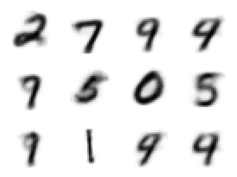

In [59]:
codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
# save_fig("vae_generated_images_plot", tight_layout=False)

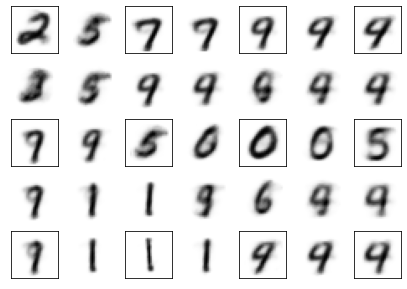

In [60]:
codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")
# save_fig("semantic_interpolation_plot", tight_layout=False)